In [1]:
from ROOT import TMVA, TFile, TTree, TCut, TString
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Concatenate, Dense, LSTM, Input, Reshape, Dropout, RNN, BatchNormalization
from tensorflow.keras.optimizers import Adagrad, SGD, RMSprop, Adam
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import eli5
from eli5.sklearn import PermutationImportance
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
import pandas as pd
import random
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, accuracy_score
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_tree
from IPython import display
import graphviz
from numba import cuda
from array import array
import pickle
import scikitplot as skplt
import seaborn as sns
import pycuda.autoinit
import pycuda.driver as drv
from pycuda.compiler import SourceModule
from math import sqrt
import swats
import gc 

Welcome to JupyROOT 6.19/01


Load signal and background trees

In [2]:
def nextPowerTwo(n):
    n = n-1
    n = n >> 1 | n
    n = n >> 2 | n
    n = n >> 4 | n
    n = n >> 8 | n
    n = n >> 16 | n
    n = n+1
    return(n)

In [3]:
drv.init()
mod=SourceModule("""
__global__ void cuda_mean(double *a, double *c, int N)
{ 
  extern __shared__ double sharedMem[256];
  int index=threadIdx.x+blockIdx.x*blockDim.x;
  int stride=blockDim.x*gridDim.x;
  sharedMem[threadIdx.x]=0;
  //if(index<N){
    //sharedMem[threadIdx.x]=b[index];
  //}
  for(int i=index;i<N;i=i+stride){
     sharedMem[threadIdx.x]+=a[i];
  }
   
   __syncthreads();
   
   for(int offset=blockDim.x/2;offset>0;offset>>=1){
      if(threadIdx.x<offset){
      sharedMem[threadIdx.x]+=sharedMem[threadIdx.x+offset];
      }
      __syncthreads();
   }
   if(threadIdx.x==0){
      c[blockIdx.x]=sharedMem[0];
   }
   
}
""")
cuda_mean1=mod.get_function("cuda_mean") 

In [4]:
drv.init()
mod=SourceModule("""
__global__ void cuda_var1(double *a,double b, double *c, int N)
{ 
  extern __shared__ double sharedMem[256];
  int index=threadIdx.x+blockIdx.x*blockDim.x;
  int stride=blockDim.x*gridDim.x;
  sharedMem[threadIdx.x]=0;
  //if(index<N){
    //sharedMem[threadIdx.x]=b[index];
  //}
  for(int i=index;i<N;i=i+stride){
     sharedMem[threadIdx.x]+=(a[i]-b)*(a[i]-b);
  }
   
   __syncthreads();
   
   for(int offset=blockDim.x/2;offset>0;offset>>=1){
      if(threadIdx.x<offset){
      sharedMem[threadIdx.x]+=sharedMem[threadIdx.x+offset];
      }
      __syncthreads();
   }
   if(threadIdx.x==0){
      c[blockIdx.x]=sharedMem[0];
   }
   
}
""")
cuda_var1=mod.get_function("cuda_var1") 

In [5]:
drv.init()
mod=SourceModule("""
__global__ void cuda_normal1(double *a,double b, double c,double *d, int N)
{ 
  int index=threadIdx.x+blockIdx.x*blockDim.x;
  int stride=blockDim.x*gridDim.x;
  for(int i=index;i<N;i=i+stride){
     d[i]=(a[i]-b)/c;
  }
   
}
""")
cuda_normal1=mod.get_function("cuda_normal1") 

In [6]:
def cuda_mean(nump1):
    leng1,ncol=nump1.shape
    mean_num=np.zeros((ncol,1))
    result=np.zeros((ncol,1))
    nThreads=256
    nBlocks=68
    c1=np.zeros((68,1))
    for i in range(0,ncol):
        input_num=np.float64(nump1[:,i].copy(order='C'))
        N=np.int32(leng1)
        cuda_mean1(drv.InOut(input_num),drv.InOut(c1),N,block=(nThreads, 1, 1),grid=(nBlocks,1))
        result[i]=sum(c1)/leng1
    return(result)
        
        
        
    

In [7]:
def cuda_var(nump1):
    leng1,ncol=nump1.shape
    mean_vec=cuda_mean(nump1)
    result=np.zeros((ncol,1))
    nThreads=256
    nBlocks=68
    c1=np.zeros((68,1))
    
    for i in range(0,ncol):
        input_num=np.float64(nump1[:,i].copy(order='C'))
        N=np.int32(leng1)
        mean1=mean_vec[i]
        cuda_var1(drv.InOut(input_num),mean1,drv.InOut(c1),N,block=(nThreads, 1, 1),grid=(nBlocks,1))
        result[i]=sum(c1)/(leng1-1)
    return(result)
    
    

In [8]:
def guass_normal(nump1,nump2):
    leng1,ncol=nump1.shape
    mean_vec=cuda_mean(nump2)
    var_vec=cuda_var(nump2)
    result=np.zeros((leng1,ncol))
    for i in range(0,ncol):
        result[:,i]=(nump1[:,i]-mean_vec[i])/sqrt(var_vec[i]+0.001)
    return(result)
    


In [9]:
def min_max_renormal(numpy_array,numpy_array1):
    mydf = pd.DataFrame(data=numpy_array)
    mydf1 = pd.DataFrame(data=numpy_array1)
    normalize_df = (mydf-mydf1.min())/(mydf1.max()-mydf1.min())
    normalize_np = normalize_df.values
    print(normalize_np)
    return(normalize_np)

In [10]:
signalFile = TFile.Open("../sample-train/sig_bbTotal.root")
backgroundFile = TFile.Open("../sample-train/bkg_total.root")

In [11]:
signalTree = signalFile.Get("ntup")
backgroundTree = backgroundFile.Get("ntup")

In [12]:
signalNum = signalTree.GetEntries()
backgroundNum = backgroundTree.GetEntries()
print("signal events number before cut is: ", signalNum)
print("background events number before cut is: ", backgroundNum)

signal events number before cut is:  379199
background events number before cut is:  18069795


Convert minitree into numpy

In [13]:
signalArray=signalTree.AsMatrix(["weight","is_em","is_me","bjet_0_pt","bjet_0_eta","bjet_1_pt","bjet_1_eta","ll_m","ll_pt","ll_deltar","ll_deltaeta","ll_deltaphi","bb_m",
                              "bb_pt","bb_deltar","bb_deltaeta","bb_deltapt","met_met","met_sig","met_phi","mt_lep0_met","mt_lep1_met","m_bbll","m_bbllmet"])
#signalArray=signalTree.AsMatrix(["weight","is_em","is_me","bjet_0_eta","bjet_1_pt","ll_m","ll_pt","ll_deltar","ll_deltaeta","ll_deltaphi","bb_m",
                                #"bb_pt","bb_deltar","bb_deltaeta","met_sig","met_phi","mt_lep0_met","mt_lep1_met"])
    
#backgroundArray=backgroundTree.AsMatrix(["weight","is_em","is_me","bjet_0_eta","bjet_1_pt","ll_m","ll_pt","ll_deltar","ll_deltaeta","ll_deltaphi","bb_m",
                                #"bb_pt","bb_deltar","bb_deltaeta","met_sig","met_phi","mt_lep0_met","mt_lep1_met"])
backgroundArray=backgroundTree.AsMatrix(["weight","is_em","is_me","bjet_0_pt","bjet_0_eta","bjet_1_pt","bjet_1_eta","ll_m","ll_pt","ll_deltar","ll_deltaeta","ll_deltaphi","bb_m",
                              "bb_pt","bb_deltar","bb_deltaeta","bb_deltapt","met_met","met_sig","met_phi","mt_lep0_met","mt_lep1_met","m_bbll","m_bbllmet"])
    
print(signalArray.shape)

(379199, 24)


In [14]:
leng,ncol=signalArray.shape
print(leng)
print(ncol)

379199
24


In [15]:
for i in range(0,ncol):
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


In [16]:
print("signal yield before cut is: ",sum(signalArray[:,0]))
print("background yield before cut is:",sum(backgroundArray[:,0]))

signal yield before cut is:  15.600508562739876
background yield before cut is: 2169748.186742322


In [ ]:
dataSignal=pd.DataFrame(data=signalArray[:,3:],columns=["bjet_0_pt","bjet_0_eta","bjet_1_pt","bjet_1_eta","ll_m","ll_pt","ll_deltar","ll_deltaeta","ll_deltaphi","bb_m",
                              "bb_pt","bb_deltar","bb_deltaeta","bb_deltapt","met_met","met_sig","met_phi","mt_lep0_met","mt_lep1_met","m_bbll","m_bbllmet"])

In [ ]:
plt.figure(figsize=(12, 12))
cor = dataSignal.corr()
cor.style.set_precision(2)
sns.heatmap(cor, annot=False, cmap=plt.cm.Reds)
figure_fig = plt.gcf()  # 'get current figure'

figure_fig.savefig('../figures/0725/corr_sig.pdf', format='pdf', dpi=500)

plt.show()

In [ ]:
dataBackground = pd.DataFrame(data=backgroundArray[:, 3:], columns=["bjet_0_pt", "bjet_0_eta", "bjet_1_pt", "bjet_1_eta", "ll_m", "ll_pt", "ll_deltar", "ll_deltaeta", "ll_deltaphi", "bb_m",
                                                                    "bb_pt", "bb_deltar", "bb_deltaeta", "bb_deltapt", "met_met", "met_sig", "met_phi", "mt_lep0_met", "mt_lep1_met", "m_bbll", "m_bbllmet"])
plt.figure(figsize=(12, 12))
cor = dataBackground.corr()
sns.heatmap(cor, annot=False, cmap=plt.cm.Reds)
figure_fig = plt.gcf()  # 'get current figure'
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
figure_fig.savefig('../figures/0725/corr_bkg.pdf', format='pdf', dpi=500)
plt.show()

In [17]:
print(signalArray)

[[ 2.01644220e-07  1.00000000e+00  0.00000000e+00 ...  8.16832910e+03
   1.01459575e+06  1.15864900e+06]
 [ 4.65245464e-05  0.00000000e+00  1.00000000e+00 ...  4.82755898e+04
   4.13342219e+05  5.49812625e+05]
 [ 4.08301212e-06  0.00000000e+00  0.00000000e+00 ...  2.39445947e+03
   4.90221562e+05  9.90220812e+05]
 ...
 [ 6.96462243e-07  0.00000000e+00  0.00000000e+00 ...  4.17481328e+04
   8.63429250e+05  8.78042938e+05]
 [ 8.11937758e-07  0.00000000e+00  0.00000000e+00 ...  2.02780938e+04
   7.03278562e+05  8.30059688e+05]
 [-3.84479825e-07  0.00000000e+00  0.00000000e+00 ...  2.43024629e+04
   5.73283750e+05  9.84956125e+05]]


In [18]:
print(signalArray[:,1])

[1. 0. 0. ... 0. 0. 0.]


Add signal Region cuts $m_{jj}>300$ Gev and $|\Delta(y_{jj})|>2.0$.

In [19]:
signalSample2=signalArray[(abs(signalArray[:,7])<75000.0)&((signalArray[:,1]==1)|(signalArray[:,2]==1))]
backgroundSample2=backgroundArray[(abs(backgroundArray[:,7])<75000.0)&((backgroundArray[:,1]==1)|(backgroundArray[:,2]==1))]

In [20]:
print(len(signalSample2))
print(len(backgroundSample2))

137995
1732496


In [21]:
signalNum=len(signalSample2)
backgroundNum=len(backgroundSample2)
print("signal event number after cut is: ",signalNum)
print("background event number after cut is:",backgroundNum)
print("signal yield after cut is: ",sum(signalSample2[:,0]))
print("background yield after cut is:",sum(backgroundSample2[:,0]))
SBratio=sum(signalSample2[:,0])/sum(backgroundSample2[:,0])
print("S/B ratio is: ",SBratio)
SigYield=sum(signalSample2[:,0])
BkgYield=sum(backgroundSample2[:,0])

signal event number after cut is:  137995
background event number after cut is: 1732496
signal yield after cut is:  7.34648033832881
background yield after cut is: 329776.6687519587
S/B ratio is:  2.227713793741564e-05


In [22]:
signalSample=signalSample2[(signalSample2[:,12]>80000)&(signalSample2[:,12]<150000)&(signalSample2[:,14]<2.8)]
backgroundSample=backgroundSample2[(backgroundSample2[:,12]>80000)&(backgroundSample2[:,12]<150000)&(backgroundSample2[:,14]<2.8)]

In [23]:
dataNormal=np.vstack((signalSample,backgroundSample))

In [24]:
print(dataNormal)

[[ 2.01644220e-07  1.00000000e+00  0.00000000e+00 ...  8.16832910e+03
   1.01459575e+06  1.15864900e+06]
 [ 4.68057891e-07  1.00000000e+00  0.00000000e+00 ...  1.32031602e+04
   9.43254438e+05  1.33605112e+06]
 [ 9.52463830e-05  0.00000000e+00  1.00000000e+00 ...  1.72273184e+04
   2.38733578e+05  3.50850750e+05]
 ...
 [-2.14947319e-02  0.00000000e+00  1.00000000e+00 ...  3.03927715e+04
   1.58977000e+05  2.03691250e+05]
 [-1.93113838e-02  1.00000000e+00  0.00000000e+00 ...  6.37618242e+04
   2.34892188e+05  3.06331094e+05]
 [ 1.98039274e-02  0.00000000e+00  1.00000000e+00 ...  8.74997031e+04
   2.00908250e+05  3.49087500e+05]]


In [25]:
print(len(signalSample))
print(len(backgroundSample))

112564
519023


In [26]:
signalNum=len(signalSample)
backgroundNum=len(backgroundSample)
print("signal event number after cut is: ",signalNum)
print("background event number after cut is:",backgroundNum)
print("signal yield after cut is: ",sum(signalSample[:,0]))
print("background yield after cut is:",sum(backgroundSample[:,0]))
SBratio=sum(signalSample[:,0])/sum(backgroundSample[:,0])
print("S/B ratio is: ",SBratio)
SigYield1=sum(signalSample[:,0])
BkgYield1=sum(backgroundSample[:,0])

signal event number after cut is:  112564
background event number after cut is: 519023
signal yield after cut is:  5.8165246586982695
background yield after cut is: 100587.2411810692
S/B ratio is:  5.782567043694758e-05


Split datasets into training and testing subsets

In [27]:
trainingRatio=0.8
sigTrainNum=int(signalNum*0.8)
backgroundTrainNum=int(backgroundNum*0.8)
sigTestNum=signalNum-sigTrainNum
backgroundTestNum=backgroundNum-backgroundTrainNum
print("training signal events number is: ",sigTrainNum)
print("testing signal events number is: ",sigTestNum)
print("training background events number is: ",backgroundTrainNum)
print("testing background events number is: ",backgroundTestNum)


training signal events number is:  90051
testing signal events number is:  22513
training background events number is:  415218
testing background events number is:  103805


In [28]:
signal_row=np.arange(0,signalNum-1,1)
background_row=np.arange(0,backgroundNum-1,1)
signal_train_row=np.random.choice(signal_row,size=sigTrainNum,replace=False)
background_train_row=np.random.choice(background_row,size=backgroundTrainNum,replace=False)
label_signal_train=np.ones((sigTrainNum,1))
label_background_train=np.zeros((backgroundTrainNum,1))
label_signal_test=np.ones((sigTestNum,1))
label_background_test=np.zeros((backgroundTestNum,1))
signalTrain1=signalSample[signal_train_row,:]
signalTest1=np.delete(signalSample,signal_train_row,axis=0)
backgroundTrain1=backgroundSample[background_train_row,:]
backgroundTest1=np.delete(backgroundSample,background_train_row,axis=0)
signalTrain1=np.concatenate((label_signal_train,signalTrain1),axis=1)
backgroundTrain1=np.concatenate((label_background_train,backgroundTrain1),axis=1)
signalTrain=signalTrain1[(signalTrain1[:,1]>0)]
backgroundTrain=backgroundTrain1[(backgroundTrain1[:,1]>0)]
signalTest1=np.concatenate((label_signal_test,signalTest1),axis=1)
backgroundTest1=np.concatenate((label_background_test,backgroundTest1),axis=1)
signalTest=signalTest1[(signalTest1[:,1]>0)]
backgroundTest=backgroundTest1[(backgroundTest1[:,1]>0)]
ratio=sum(signalTrain[:,1])/sum(backgroundTrain[:,1])
signalTrain[:,1]=signalTrain[:,1]/ratio
print(backgroundTest)
print(ratio)
ratio1=sum(signalTest[:,1])/sum(backgroundTest[:,1])
signalTest[:,1]=signalTest[:,1]/ratio


[[0.00000000e+00 2.16044893e-02 0.00000000e+00 ... 2.70216738e+04
  1.98443656e+05 2.25258797e+05]
 [0.00000000e+00 1.99212377e-02 1.00000000e+00 ... 1.80047227e+04
  1.97423828e+05 2.53930453e+05]
 [0.00000000e+00 7.70894253e-02 1.00000000e+00 ... 6.23529180e+04
  2.28640109e+05 3.24432000e+05]
 ...
 [0.00000000e+00 6.46731398e-03 0.00000000e+00 ... 5.49901055e+04
  3.33906875e+05 3.58692625e+05]
 [0.00000000e+00 2.67451608e-02 0.00000000e+00 ... 1.02244398e+05
  2.49280000e+05 3.52089531e+05]
 [0.00000000e+00 1.98039274e-02 0.00000000e+00 ... 8.74997031e+04
  2.00908250e+05 3.49087500e+05]]
6.866946821738034e-05


In [29]:
dataTrain=np.vstack((signalTrain,backgroundTrain))
dataTest=np.vstack((signalTest,backgroundTest))
np.random.shuffle(dataTrain)
np.random.shuffle(dataTest)
dataTrainLabel=dataTrain[:,0]
dataTrainWeight=dataTrain[:,1]
dataTrainSample=dataTrain[:,4:]
dataTestLabel=dataTest[:,0]
dataTestWeight=dataTest[:,1]
dataTestSample=dataTest[:,4:]
tf.cast(dataTrainLabel,tf.float32)
tf.cast(dataTrainSample,tf.float32)

<tf.Tensor 'Cast_1:0' shape=(487847, 21) dtype=float32>

Signal and background training sets should have same yield in training

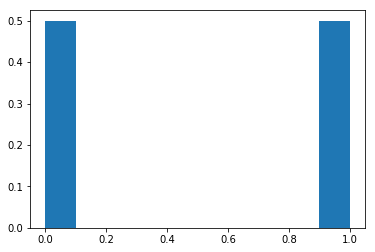

In [30]:
dataTrainWeight=dataTrainWeight/sum(dataTrainWeight)
plt.hist(dataTrain[:,0],weights=dataTrainWeight)
dataTrainWeight=dataTrainWeight.transpose()


In [31]:
average_train_weight=dataTrainWeight.mean()

In [32]:
dataTestWeight=dataTestWeight/sum(dataTestWeight)
plt.hist(dataTest[:,0],weights=dataTestWeight)

(array([0.49973735, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.50026265]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

In [33]:
average_test_weight=dataTestWeight.mean()

Build model

In [34]:
print(guass_normal(signalSample[:,3:],dataNormal[:,3:]))

[[ 2.57617071 -0.85320146  0.86671809 ... -1.38468285  4.71239126
   3.17054935]
 [ 1.7282203  -2.07105752  3.5903252  ... -1.22499071  4.25410101
   3.93093625]
 [-0.0480364   0.65809505  0.95921796 ... -1.09735457 -0.27167829
  -0.29186242]
 ...
 [-0.24293654 -1.04643771 -0.79910598 ... -0.76473147  0.58760723
   0.11588736]
 [-0.11177585  0.58539063 -0.92493021 ... -1.61121685  0.496202
   1.04256256]
 [ 0.63453273 -0.91844763  1.13224548 ...  0.78449766  0.69671395
   1.23619128]]


In [35]:
dataTrainSample1=guass_normal(dataTrainSample,dataNormal[:,3:])
dataTestSample1=guass_normal(dataTestSample,dataNormal[:,3:])

In [36]:
signalSample1=guass_normal(signalSample[:,3:],dataNormal[:,3:])
backgroundSample1=guass_normal(backgroundSample[:,3:],dataNormal[:,3:])

In [ ]:
model = Sequential()
model.add(Dense(300, kernel_initializer="glorot_normal", activation="relu",
    input_dim=21))
model.add(BatchNormalization(momentum=0.5, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None))
model.add(Dense(300, kernel_initializer="random_normal", activation="relu"))
model.add(BatchNormalization(momentum=0.5, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None))
model.add(Dense(300, kernel_initializer="random_normal", activation="relu"))
model.add(BatchNormalization(momentum=0.5, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None))
model.add(Dense(300, kernel_initializer="random_normal", activation="relu"))
model.add(BatchNormalization(momentum=0.5, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None))
model.add(Dense(300, kernel_initializer="random_normal", activation="relu"))
model.add(BatchNormalization(momentum=0.5, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None))
model.add(Dense(300, kernel_initializer="random_normal", activation="relu"))
model.add(Dense(300, kernel_initializer="random_normal", activation="relu"))
model.add(Dense(1, kernel_initializer="glorot_uniform", activation="sigmoid"))

# Set loss, optimizer and evaluation metrics
model.compile(
     loss="binary_crossentropy",
     #optimizer=Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False),
      optimizer='adam',
     #optimizer=SGD(lr=0.01, momentum=0.5, decay=0.8, nesterov=True),
     metrics=["acc"])

In [ ]:
early_stopping=tf.keras.callbacks.EarlyStopping(monitor='loss',
                              min_delta=0,
                              patience=3,
                              verbose=0, mode='auto')

In [ ]:
model.save('model_HHZZ.h5')
model.summary()

In [ ]:
model.fit(dataTrainSample1,dataTrainLabel,batch_size=100, epochs=30,
          sample_weight=dataTrainWeight,
          callbacks=[early_stopping])

In [ ]:
signalNN=model.predict(signalSample1)
backgroundNN=model.predict(backgroundSample1)
plt.hist(signalNN,bins=20)
plt.hist(backgroundNN,bins=20)
NNTrainScore=model.predict(dataTrainSample1)

In [ ]:
plt.hist(backgroundNN,bins=20,weights=backgroundSample[:,0])

In [ ]:
plt.hist(signalNN,bins=20,weights=signalSample[:,0])

In [ ]:
backgroundNN=model.predict(backgroundSample1)
plt.hist(backgroundNN,bins=20)

Save NN model to h5 file

In [ ]:
model.save('../NN_model/0716/_NNmodel_region4.h5')
model.summary()

In [ ]:
signalNNScore=model.predict(signalSample1)
#backgroundNNScore=model.predict(backgroundArray[:,1:])
print(signalNNScore)

In [ ]:
plt.hist(signalNNScore,bins=20)

In [ ]:
def baseline_model():
    model = Sequential()
    model.add(Dense(300, kernel_initializer="glorot_normal", activation="relu",
         input_dim=21))
    model.add(Dense(300, kernel_initializer="random_normal", activation="relu"))
    model.add(Dense(300, kernel_initializer="random_normal", activation="relu"))
    model.add(Dense(300, kernel_initializer="random_normal", activation="relu"))
    model.add(Dense(300, kernel_initializer="random_normal", activation="relu"))
    model.add(Dense(300, kernel_initializer="random_normal", activation="relu"))
    model.add(Dense(300, kernel_initializer="random_normal", activation="relu"))
    model.add(Dense(1, kernel_initializer="glorot_uniform", activation="sigmoid"))
    model.compile(
     loss="binary_crossentropy",
     optimizer="adam",
     metrics=["accuracy"])
    return model

In [ ]:
estimator = KerasRegressor(build_fn=baseline_model, nb_epoch=30, batch_size=50, verbose=False)
estimator.fit(dataTrainSample1,dataTrainLabel,sample_weight=dataTrainWeight)
perm = PermutationImportance(estimator, random_state=1).fit(dataTrainSample1,dataTrainLabel)

In [ ]:
eli5.show_weights(perm,feature_names=["bjet_0_pt","bjet_0_eta","bjet_1_pt","bjet_1_eta","ll_m","ll_pt","ll_deltar","ll_deltaeta","ll_deltaphi","bb_m",
                                "bb_pt","bb_deltar","bb_deltaeta","bb_deltapt","met_met","met_sig","met_phi","mt_lep0_met","mt_lep1_met","m_bbll","m_bbllmet"])

In [ ]:
cuda.select_device(0)
cuda.close()

In [37]:
drv.init()
device = torch.device("cuda:0")
y_tensor = torch.tensor(dataTrainLabel, dtype=torch.float).to(device)
WeightTensor=torch.tensor((dataTrainWeight), dtype=torch.float).to(device)
dataTrainTensor=torch.tensor(dataTrainSample1, dtype=torch.float).to(device)
dataTestTensor=torch.tensor(dataTestSample1,dtype=torch.float).to(device)
TrainDataset = TensorDataset( WeightTensor, dataTrainTensor, y_tensor)
TrainLoader = DataLoader(TrainDataset, batch_size=5000, shuffle=False)
TestWeightTensor=torch.tensor(dataTestWeight,dtype=torch.float).to(device)
test_y_tensor=torch.tensor(dataTestLabel, dtype=torch.float).to(device)
TestDataset = TensorDataset((TestWeightTensor), dataTestTensor, test_y_tensor)
TestLoader = DataLoader(TestDataset, batch_size=10000, shuffle=False)

In [38]:
class Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(21, 300)
        self.relu1 = nn.ReLU()
        self.dout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(300, 300)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(300, 300)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(300, 300)
        self.relu4 = nn.ReLU()
        self.out = nn.Linear(300, 1)
        self.out_act = nn.Sigmoid()
        
    def forward(self, input_):
        a1 = self.fc1(input_)
        h1 = self.relu1(a1)
        dout = self.dout(h1)
        a2 = self.fc2(dout)
        h2 = self.relu2(a2)
        a3 = self.fc2(h2)
        h3 = self.relu3(a3)
        a4 = self.fc2(h3)
        h4 = self.relu4(a4)
        a5 = self.out(h4)
        y = self.out_act(a5)
        return y

In [39]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_normal_(m.weight)
        m.bias.data.fill_(0.01)

In [40]:
def custom_loss(y_pred,y,weights):
    loss=torch.mean((y*torch.exp(5*(1-y_pred))+(1-y)*torch.exp(5*(y_pred)))*weights)
    return loss

In [41]:
def train(model, device, train_loader, loss_function, optimizer, epoch):
    model.train()
    average_loss=0
    batch_n=0
    for batch_idx, (sample_weight, data, target) in enumerate(train_loader):
        batch_n=batch_n+1
        data, target,sample_weight = data, target, sample_weight
        
        optimizer.zero_grad()
        data=data.squeeze()
        output = model(data)
        loss_function.weight = sample_weight/average_train_weight
        #my_weight=sample_weight/sample_weight.mean()
        output=output.reshape(-1)
        loss = loss_function(output, target)
        #loss = custom_loss(output, target,my_weight)
        loss.backward()
        average_loss=average_loss+loss.item()
        optimizer.step()
        torch.cuda.empty_cache()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    print("Average loss in epoch ",epoch," is: ",average_loss/batch_n)
    return(average_loss/batch_n)

In [42]:
def eval_train(model,device,input_loader,loss_function):
    average_loss=0
    batch_n=0
    model.eval()
    with torch.no_grad():
        for batch_idx, (sample_weight, data, target) in enumerate(input_loader):
            batch_n=batch_n+1
            data, target,sample_weight = data, target, sample_weight
            output = model(data)
            output=output.reshape(-1)
            loss_function.weight = sample_weight/average_test_weight
            loss = loss_function(output, target)
            average_loss=average_loss+loss.item()
    return(average_loss/batch_n)

In [43]:
model = Net().to(device)
model.apply(init_weights)

Net(
  (fc1): Linear(in_features=21, out_features=300, bias=True)
  (relu1): ReLU()
  (dout): Dropout(p=0.2)
  (fc2): Linear(in_features=300, out_features=300, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=300, out_features=300, bias=True)
  (relu3): ReLU()
  (fc4): Linear(in_features=300, out_features=300, bias=True)
  (relu4): ReLU()
  (out): Linear(in_features=300, out_features=1, bias=True)
  (out_act): Sigmoid()
)

In [44]:
loss_fn =nn.BCELoss().cuda()
#loss_fn=custom_loss()
#optimizer = optim.Adam(model.parameters())
optimizer=swats.SWATS(model.parameters())
#optimizer = optim.SGD(model.parameters(), lr=1e-4, momentum=0.6)
#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

In [45]:
lowest_loss=9999
counter=0
best_epoch=0
pat=4
loss_np=np.zeros((300,1))
loss_test_np=np.zeros((300,1))
for epoch in range(1, 300):
        loss_epoch=train(model, device, TrainLoader,loss_fn, optimizer, epoch)
        loss_test_epoch=eval_train(model, device, TestLoader,loss_fn)
        loss_np[epoch-1]=loss_epoch
        loss_test_np[epoch-1]=loss_test_epoch
        if(loss_test_epoch<lowest_loss):
            counter=0
            best_epoch=epoch
            lowest_loss=loss_test_epoch
        else:
            counter=counter+1
        if(counter==pat):
            print("Stopping, best epoch is: ",best_epoch," lowest loss is: ",lowest_loss)
            break
        

Train Epoch: 1 [0/487847 (0%)]	Loss: 0.731975
Train Epoch: 1 [50000/487847 (10%)]	Loss: 0.414337
Train Epoch: 1 [100000/487847 (20%)]	Loss: 0.396675
Train Epoch: 1 [150000/487847 (31%)]	Loss: 0.316361
Train Epoch: 1 [200000/487847 (41%)]	Loss: 0.357153
Train Epoch: 1 [250000/487847 (51%)]	Loss: 0.360923
Train Epoch: 1 [300000/487847 (61%)]	Loss: 0.318915
Train Epoch: 1 [350000/487847 (71%)]	Loss: 0.358635
Train Epoch: 1 [400000/487847 (82%)]	Loss: 0.392498
Train Epoch: 1 [450000/487847 (92%)]	Loss: 0.393419
Average loss in epoch  1  is:  0.3794663326472652
Train Epoch: 2 [0/487847 (0%)]	Loss: 0.403373
Train Epoch: 2 [50000/487847 (10%)]	Loss: 0.336261
Train Epoch: 2 [100000/487847 (20%)]	Loss: 0.350855
Train Epoch: 2 [150000/487847 (31%)]	Loss: 0.270534
Train Epoch: 2 [200000/487847 (41%)]	Loss: 0.336623
Train Epoch: 2 [250000/487847 (51%)]	Loss: 0.346164
Train Epoch: 2 [300000/487847 (61%)]	Loss: 0.300144
Train Epoch: 2 [350000/487847 (71%)]	Loss: 0.345810
Train Epoch: 2 [400000/48784

In [64]:
loss_train=loss_np[:best_epoch+3,0]
train_step=range(1,best_epoch+4)
fig, ax = plt.subplots(figsize=(8,5))
ax.set_ylabel('Binary Cross Entropy',fontsize=15)
ax.set_xlabel('Epochs',fontsize=15)
ax.set_title('Learning Curve (train)',fontsize=15)
ax.grid()
x = train_step
y = loss_train
l = ax.plot(x, y)
dot, = ax.plot([], [], 'ro')
def init():
    ax.set_xlim(0,best_epoch+4)
    ax.set_ylim(0.2,0.4)
    return l

def gen_dot():
    for i in range(1,best_epoch+4):
        newdot = [x[i-1], y[i-1]]
        yield newdot

def update_dot(newd):
    dot.set_data(newd[0], newd[1])
    return dot,

ani = animation.FuncAnimation(fig, update_dot, frames = gen_dot, interval = 100, init_func=init)
ani.save('../figures/0813/loss-region4.gif', writer='imagemagick', fps=30)
plt.show()

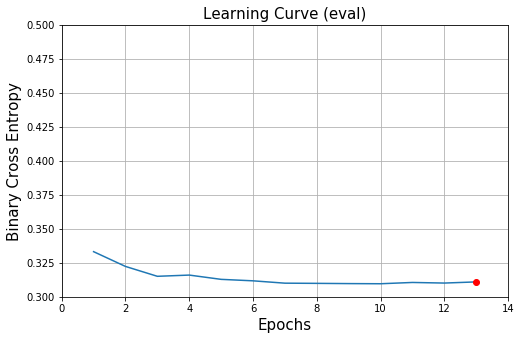

In [47]:
loss_train=loss_test_np[:best_epoch+3,0]
train_step=range(1,best_epoch+4)
fig, ax = plt.subplots(figsize=(8,5))
ax.set_ylabel('Binary Cross Entropy',fontsize=15)
ax.set_xlabel('Epochs',fontsize=15)
ax.set_title('Learning Curve (eval)',fontsize=15)
ax.grid()
x = train_step
y = loss_train
l = ax.plot(x, y)
dot, = ax.plot([], [], 'ro')
def init():
    ax.set_xlim(0,best_epoch+4)
    ax.set_ylim(0.3,0.5)
    return l

def gen_dot():
    for i in range(1,best_epoch+4):
        newdot = [x[i-1], y[i-1]]
        yield newdot

def update_dot(newd):
    dot.set_data(newd[0], newd[1])
    return dot,

ani = animation.FuncAnimation(fig, update_dot, frames = gen_dot, interval = 100, init_func=init)
ani.save('../figures/0806/loss-region4-test.gif', writer='imagemagick', fps=30)
plt.show()

In [48]:
del TrainLoader
torch.cuda.empty_cache()
del TrainDataset
torch.cuda.empty_cache()
#del dataTrainTensor
#torch.cuda.empty_cache()
del WeightTensor
torch.cuda.empty_cache()

In [49]:
def eval_pytorch(model,device,input_loader):
    output_numpy=[1]
    model.eval()
    with torch.no_grad():
        for batch_idx, (data1) in enumerate(input_loader):
            score=model(data1)
            del data1
            score_np=score.data.cpu().numpy()
            output_numpy=np.vstack((output_numpy,score_np))
            torch.cuda.empty_cache()
    return(output_numpy)

In [50]:
signalTensor = torch.tensor(signalSample1, dtype=torch.float, device=device)
signalLoader=DataLoader(signalTensor,batch_size=10000, shuffle=False)

[0.97883213 0.9860394  0.93141812 ... 0.66358638 0.96134555 0.98801863]
112564


(array([0.02707675, 0.02944289, 0.04466047, 0.05574128, 0.07228034,
        0.07566499, 0.09171612, 0.11763962, 0.13422862, 0.11935928,
        0.11871038, 0.13842816, 0.15449201, 0.15743701, 0.19879834,
        0.21377259, 0.26712948, 0.35588656, 0.63573452, 2.80832522]),
 array([9.23581297e-07, 5.00007344e-02, 1.00000545e-01, 1.50000356e-01,
        2.00000167e-01, 2.49999977e-01, 2.99999788e-01, 3.49999599e-01,
        3.99999410e-01, 4.49999221e-01, 4.99999031e-01, 5.49998842e-01,
        5.99998653e-01, 6.49998464e-01, 6.99998274e-01, 7.49998085e-01,
        7.99997896e-01, 8.49997707e-01, 8.99997517e-01, 9.49997328e-01,
        9.99997139e-01]),
 <a list of 20 Patch objects>)

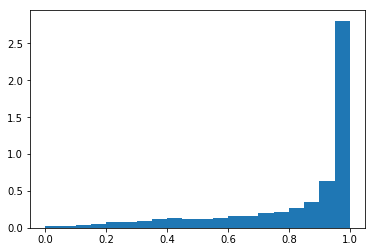

In [51]:
sigScore = eval_pytorch(model,device,signalLoader)
sigScore=sigScore[1:,0]
print(sigScore)
print(len(sigScore))
plt.hist(sigScore,bins=20,weights=signalSample[:,0])

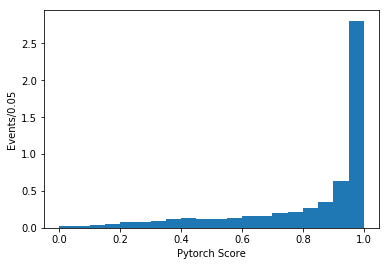

In [52]:
plt.hist(sigScore,bins=20,weights=signalSample[:,0])
plt.ylabel('Events/0.05')
plt.xlabel('Pytorch Score')
figure_fig = plt.gcf()  # 'get current figure'
figure_fig.savefig('../figures/0806/NN-region4-sig.pdf', format='pdf', dpi=500)
plt.show()

In [53]:
bakTensor= torch.tensor(backgroundSample1, dtype=torch.float,device=device)
backgroundLoader=DataLoader(bakTensor,batch_size=10000, shuffle=False)
bakScore = eval_pytorch(model,device,backgroundLoader)

In [54]:
bakScore=bakScore[1:,0]
print(bakScore)
print(len(bakScore))

[0.2013151  0.12621507 0.21469566 ... 0.19632788 0.11256751 0.00369454]
519023


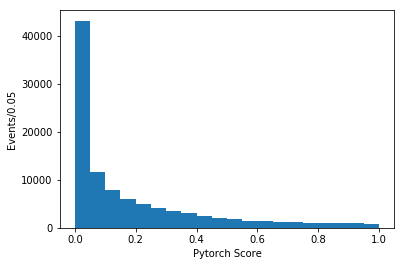

In [55]:
plt.hist(bakScore,bins=20,weights=backgroundSample[:,0])
plt.ylabel('Events/0.05')
plt.xlabel('Pytorch Score')
figure_fig = plt.gcf()  # 'get current figure'
figure_fig.savefig('../figures/0806/NN-region4-bkg.pdf', format='pdf', dpi=500)
plt.show()

In [ ]:
gc.collect()

In [ ]:
signalFile.Close()
backgroundFile.Close()

sigFile=TFile.Open("../sample-0718/bkg_fake.root", "update")
bkgFile=TFile.Open("../sample-0718/bkg_diboson.root","update")
sigTree=sigFile.Get("ntup")
bkgTree=bkgFile.Get("ntup")
sR1BDT=array("f",[0])
bR1BDT=array("f",[0])
sigRegion1BDTBranch=sigTree.Branch("BDT_Region1",sR1BDT,"BDT_Region1/F")
bkgRegion1BDTBranch=bkgTree.Branch("BDT_Region1",bR1BDT,"BDT_Region1/F")


In [ ]:
i=0
for (scoreR1,scoreR2,scoreR3,scoreR4) in zip(sigRegion1BDTScore,sigRegion2BDTScore,sigRegion3BDTScore,sigRegion4BDTScore):
    i=i+1
    if(i%5000==0):
        print("looping: ",i)
    sR1BDT[0]=scoreR1
    sR2BDT[0]=scoreR2
    sR3BDT[0]=scoreR3
    sR4BDT[0]=scoreR4
    sigRegion1BDTBranch.Fill()
    sigRegion2BDTBranch.Fill()
    sigRegion3BDTBranch.Fill()
    sigRegion4BDTBranch.Fill()
    
sigTree.Write()
sigFile.Write()
sigFile.Close()

In [56]:
dataTrainTensor= torch.tensor(dataTrainSample1, dtype=torch.float,device=device)
dataTrainLoader=DataLoader(dataTrainTensor,batch_size=10000, shuffle=False)
TrainScore = eval_pytorch(model,device,dataTrainLoader)
TrainScore=TrainScore[1:,0]

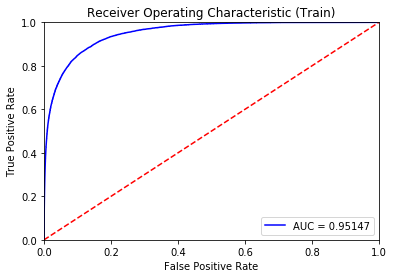

In [57]:
fpr, tpr, threshold=sklearn.metrics.roc_curve(dataTrainLabel,TrainScore,sample_weight=dataTrainWeight)
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic (Train)')
plt.plot(fpr, tpr, 'b',label = 'AUC = %0.5f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
figure_fig = plt.gcf()  # 'get current figure'
figure_fig.savefig('../figures/0813/roc-region4-train-NN.pdf', format='pdf', dpi=500)
plt.show()

In [58]:
dataTestTensor= torch.tensor(dataTestSample1, dtype=torch.float,device=device)
dataTestLoader=DataLoader(dataTestTensor,batch_size=10000, shuffle=False)
TestScore = eval_pytorch(model,device,dataTestLoader)
TestScore=TestScore[1:,0]

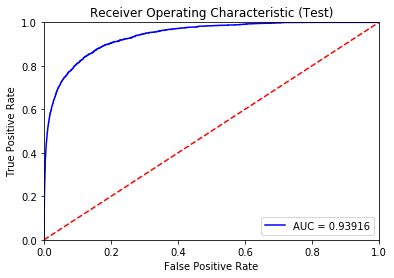

In [59]:
fpr, tpr, threshold=sklearn.metrics.roc_curve(dataTestLabel,TestScore,sample_weight=dataTestWeight)
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic (Test)')
plt.plot(fpr, tpr, 'b',label = 'AUC = %0.5f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
figure_fig = plt.gcf()  # 'get current figure'
figure_fig.savefig('../figures/0813/roc-region4-test-NN.pdf', format='pdf', dpi=500)
plt.show()

In [ ]:
torch.save(model,"../NN_model/region4-pytorch.pickle.dat")

In [ ]:
model.save_state_dict('../NN_model/region4-pytorch.pt')

In [63]:
torch.save(model.state_dict(),'../NN_model/region4-pytorch-0813.pt')

In [ ]:
del bakTensor
torch.cuda.empty_cache()

In [ ]:
cuda.select_device(0)
cuda.close()

In [ ]:
varName=["bjet_0_pt","bjet_0_eta","bjet_1_pt","bjet_1_eta","ll_m","ll_pt","ll_deltar","ll_deltaeta","ll_deltaphi","bb_m",
                              "bb_pt","bb_deltar","bb_deltaeta","bb_deltapt","met_met","met_sig","met_phi","mt_lep0_met","mt_lep1_met","m_bbll","m_bbllmet"]
BDTtrain=xgb.DMatrix(dataTrainSample,label=dataTrainLabel,weight=dataTrainWeight,feature_names=varName)
BDTtest=xgb.DMatrix(dataTestSample,label=dataTestLabel,weight=dataTestWeight,feature_names=varName)
BDTSignal=xgb.DMatrix(signalSample[:,3:],feature_names=varName)
BDTBackground=xgb.DMatrix(backgroundSample[:,3:],feature_names=varName)
param = {'max_depth': 4, 'eta':0.1,'silent': 1, 'objective': 'binary:logistic'}
param['nthread'] = 16
param['eval_metric'] = 'auc'
param['tree_method'] = 'gpu_hist'
param['grow_policy'] = 'depthwise'
#param['subsample']=0.9
evallist = [(BDTtest, 'eval'), (BDTtrain, 'train')]
#eta_list=[0.1]*10+[0.05]*20+[0.02]*40+[0.01]*930

In [ ]:
num_round = 1000
GBDT = xgb.train(param, BDTtrain, num_round, evallist,early_stopping_rounds=5)

In [ ]:
GBDT=pickle.load(open("../BDT_model/GBDT_HH_region3-0.01.pickle.dat", "rb"))

In [ ]:
xgb.plot_importance(GBDT,importance_type="gain")
figure_fig = plt.gcf()  # 'get current figure'
figure_fig.savefig('../figures/0725/ranking-region4-gain.pdf', format='pdf', dpi=500)

In [ ]:
xgb.plot_importance(GBDT,importance_type="weight")
figure_fig = plt.gcf()  # 'get current figure'
figure_fig.savefig('../figures/0725/ranking-region4-weight.pdf', format='pdf', dpi=500)

In [ ]:
xgb.plot_importance(GBDT,importance_type="cover")
figure_fig = plt.gcf()  # 'get current figure'
figure_fig.savefig('../figures/0725/ranking-region4-coverage.pdf', format='pdf', dpi=500)

In [ ]:
SignalScore=GBDT.predict(BDTSignal)
#plt.hist(SignalScore,bins=20)
BackgroundScore=GBDT.predict(BDTBackground)
plt.hist(BackgroundScore,bins=20,weights=backgroundSample[:,0])
plt.ylabel('Events/0.05')
plt.xlabel('BDT Score')
figure_fig = plt.gcf()  # 'get current figure'
figure_fig.savefig('../figures/0725/BDT-region4-bkg.pdf', format='pdf', dpi=500)
plt.show()

In [ ]:
BackgroundScore=GBDT.predict(BDTBackground)
plt.hist(BackgroundScore,bins=20,range=[0.9, 1.0],weights=backgroundSample[:,0])
plt.ylabel('Events/0.05')
plt.xlabel('BDT Score')
figure_fig = plt.gcf()  # 'get current figure'
figure_fig.savefig('../figures/0725/BDT-region4-bkg-high.pdf', format='pdf', dpi=500)
plt.show()

In [ ]:
BDTBackground1=xgb.DMatrix(backgroundArray[:,3:],feature_names=varName)
BackgroundScore1=GBDT.predict(BDTBackground1)
plt.hist(BackgroundScore1,bins=10,range=[0.9,1.0])
plt.ylabel('Events/0.05')
plt.xlabel('BDT Score')
plt.show()

In [ ]:
plt.hist(SignalScore,bins=20,weights=signalSample[:,0])
plt.ylabel('Events/0.05')
plt.xlabel('BDT Score')
figure_fig = plt.gcf()  # 'get current figure'
figure_fig.savefig('../figures/0725/BDT-region4-sig.pdf', format='pdf', dpi=500)
plt.show()

In [ ]:
plot_tree(GBDT, num_trees=4)

In [ ]:
trainScore=GBDT.predict(BDTtrain)
testScore=GBDT.predict(BDTtest)
plt.hist(trainScore,bins=20)

In [ ]:
fpr, tpr, threshold=sklearn.metrics.roc_curve(dataTrainLabel,trainScore)
roc_auc = sklearn.metrics.auc(fpr, tpr)

In [ ]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label = 'AUC = %0.5f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
figure_fig = plt.gcf()  # 'get current figure'
figure_fig.savefig('../figures/0725/roc-region4-train-BDT.pdf', format='pdf', dpi=500)
plt.show()

In [ ]:
fpr, tpr, threshold=sklearn.metrics.roc_curve(dataTrainLabel,NNTrainScore)
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label = 'AUC = %0.5f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
pickle.dump(GBDT, open("../BDT_model/0716/GBDT_HH_region4_01.pickle.dat", "wb"))

In [ ]:
fpr, tpr, threshold=sklearn.metrics.roc_curve(dataTestLabel,testScore)
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
figure_fig = plt.gcf()  # 'get current figure'
figure_fig.savefig('../figures/0715/roc-region4-test.pdf', format='pdf', dpi=500)
plt.show()

In [60]:
drv.init()
mod=SourceModule("""
__global__ void func1(double *a, double *b, double *c,double thre, int N)
{ 
  extern __shared__ double sharedMem[256];
  double x=0;
  int index=threadIdx.x+blockIdx.x*blockDim.x;
  int stride=blockDim.x*gridDim.x;
  sharedMem[threadIdx.x]=0;
  //if(index<N){
    //sharedMem[threadIdx.x]=b[index];
  //}
  for(int i=index;i<N;i=i+stride){
     if(a[i]>thre){
     sharedMem[threadIdx.x]+=b[i];
     }
  }
   
   __syncthreads();
   
   for(int offset=blockDim.x/2;offset>0;offset>>=1){
      if(threadIdx.x<offset){
      sharedMem[threadIdx.x]+=sharedMem[threadIdx.x+offset];
      }
      __syncthreads();
   }
   if(threadIdx.x==0){
      c[blockIdx.x]=sharedMem[0];
   }
   
}
""")
func1=mod.get_function("func1") 

In [61]:
def cuda_sum(nump1,nump2,th):
    num1=np.float64(nump1.copy(order='C'))
    num2=np.float64(nump2.copy(order='C'))
    thres=np.float64(th)
    nThreads=256
    nBlocks=68
    c1=np.zeros((68,1))
    N=np.int32(len(nump1))
    func1(drv.InOut(num1),drv.InOut(num2),drv.InOut(c1),thres,N,block=(nThreads, 1, 1),grid=(nBlocks,1))
    return(sum(c1))

In [ ]:
resB=cuda_sum(BackgroundScore,backgroundSample[:,0],0.9)
resS=cuda_sum(SignalScore,signalSample[:,0],0.9)
SBratio1=resS/resB
Sig1=resS/sqrt(resB)
print("If cut BDT at 0.9, signal yield is:",resS," Eff is:", resS/SigYield," background yield is:",resB,
      " Eff is: ", resB/BkgYield," S/B ratio is: ",SBratio1," Significance is: ",Sig1)
resB=cuda_sum(BackgroundScore,backgroundSample[:,0],0.95)
resS=cuda_sum(SignalScore,signalSample[:,0],0.95)
SBratio2=resS/resB
Sig2=resS/sqrt(resB)
print("If cut BDT at 0.95, signal yield is:",resS," Eff is:", resS/SigYield," background yield is:",resB,
      " Eff is: ", resB/BkgYield," S/B ratio is: ",SBratio2," Significance is: ",Sig2)
resB=cuda_sum(BackgroundScore,backgroundSample[:,0],0.975)
resS=cuda_sum(SignalScore,signalSample[:,0],0.975)
SBratio3=resS/resB
Sig3=resS/sqrt(resB)
print("If cut BDT at 0.975, signal yield is:",resS," Eff is:", resS/SigYield," background yield is:",resB,
      " Eff is: ", resB/BkgYield," S/B ratio is: ",SBratio3," Significance is: ",Sig3)

In [ ]:
i=0.1
eff=(0.8,0.7,0.6,0.5,0.4,0.3)
j=0
print(eff)
for i in np.arange(0,1,0.001):
    resS=cuda_sum(SignalScore,signalSample[:,0],i)
    ratio=resS/SigYield
    if((abs(ratio-0.8)<0.01)|(abs(ratio-0.7)<0.001)|(abs(ratio-0.6)<0.01)|(abs(ratio-0.5)<0.01)|(abs(ratio-0.4)<0.01)):
        print("sig Eff: ",ratio," and BDT cut is: ",i)
    

In [ ]:
i=0.1
eff=(0.8,0.7,0.6,0.5,0.4,0.3)
j=0
k=0
t=0
min_diff=100
print(eff)
for i in np.arange(0,1,0.001):
    if(j>=6):
        break
    resS=cuda_sum(SignalScore,signalSample[:,0],i)
    ratio=resS/SigYield
    if(abs(ratio-eff[j])<0.05):
        t=1
        if(k==0):
            min_diff=100
        if(abs(ratio-eff[j])<min_diff):
            min_diff=abs(ratio-eff[j])
            BDT_cut=i
        k=k+1
           
    if(abs(ratio-eff[j])>0.05):
        if(t==1):
            j=j+1
            k=0
            t=0
            resB=cuda_sum(BackgroundScore,backgroundSample[:,0],BDT_cut)
            resS=cuda_sum(SignalScore,signalSample[:,0],BDT_cut)
            SBratio=resS/resB
            Sig=resS/sqrt(resB)
            print("If cut BDT at ",BDT_cut, "signal yield is:",resS," Eff is:", resS/SigYield," background yield is:",resB,
              " Eff is: ", resB/BkgYield," S/B ratio is: ",SBratio," Significance is: ",Sig)
    
    

In [ ]:
plt.hist(bakScore,bins=20,weights=backgroundSample[:,0])

In [ ]:
plt.hist(sigScore,bins=20,weights=signalSample[:,0])

In [62]:
i=0.1
eff=(0.8,0.7,0.6,0.5,0.4,0.3)
j=0
k=0
t=0
min_diff=100
print(eff)
for i in np.arange(0,1,0.001):
    if(j>=6):
        break
    resS=cuda_sum(sigScore,signalSample[:,0],i)
    ratio=resS/SigYield
    if(abs(ratio-eff[j])<0.1):
        t=1
        if(k==0):
            min_diff=100
        if(abs(ratio-eff[j])<min_diff):
            min_diff=abs(ratio-eff[j])
            BDT_cut=i
        k=k+1
           
    if(abs(ratio-eff[j])>0.05):
        if(t==1):
            j=j+1
            k=0
            t=0
            resB=cuda_sum(bakScore,backgroundSample[:,0],BDT_cut)
            resS=cuda_sum(sigScore,signalSample[:,0],BDT_cut)
            SBratio=resS/resB
            Sig=resS/sqrt(resB)
            print("If cut NN at ",BDT_cut, "signal yield is:",resS," Eff is:", resS/SigYield," background yield is:",resB,
              " Eff is: ", resB/BkgYield," S/B ratio is: ",SBratio," Significance is: ",Sig)

(0.8, 0.7, 0.6, 0.5, 0.4, 0.3)
If cut NN at  0.0 signal yield is: [5.81652466]  Eff is: [0.79174304]  background yield is: [100587.24118107]  Eff is:  [0.30501624]  S/B ratio is:  [5.78256704e-05]  Significance is:  [0.0183397]
If cut NN at  0.463 signal yield is: [5.14198976]  Eff is: [0.69992561]  background yield is: [13356.13089498]  Eff is:  [0.04050053]  S/B ratio is:  [0.00038499]  Significance is:  [0.04449292]
If cut NN at  0.72 signal yield is: [4.4082218]  Eff is: [0.60004541]  background yield is: [5489.8516374]  Eff is:  [0.01664718]  S/B ratio is:  [0.00080298]  Significance is:  [0.05949537]
If cut NN at  0.87 signal yield is: [3.67502337]  Eff is: [0.50024273]  background yield is: [2412.63538484]  Eff is:  [0.00731597]  S/B ratio is:  [0.00152324]  Significance is:  [0.07481941]
If cut NN at  0.9430000000000001 signal yield is: [2.9259103]  Eff is: [0.39827375]  background yield is: [1004.97886428]  Eff is:  [0.00304745]  S/B ratio is:  [0.00291141]  Significance is:  

In [ ]:
for i in np.arange(0,1,0.001):
    resB=cuda_sum(BackgroundScore,backgroundSample[:,0],i)
    print(resB/BkgYield)
    

In [ ]:
print("If cut at 0.9,   improvment is: ",SBratio1/SBratio)
print("If cut at 0.95,  improvment is: ",SBratio2/SBratio)
print("If cut at 0.975, improvment is: ",SBratio3/SBratio)